In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
pi = np.pi
clight = 299792458

In [2]:
working_folder = 'FB_debug_Ig_0100_2.5/000000000000nmacro1_nBin33_Idc2.50A_ThetaL-2.0degree_delay0.000us_gain0.00_0.00/'
home = os.getcwd()
cwd = working_folder#os.path.join(home,working_folder)
#get the starting index in the folder name string that represent the substring of current
i_start_current = working_folder.find('Idc')+3

#get the starting index in the folder name string that represent the substring of loading angle
i_start_thetaL = working_folder.find('ThetaL')+6

current = float(working_folder[working_folder.find('Idc')+3:working_folder.find('Idc')+3+4])
thetaL = float(working_folder[working_folder.find('ThetaL')+6:working_folder.find('ThetaL')+6+4])/180*pi


In [3]:
thetaL/pi*180

-2.0

In [4]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [5]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6
clight = 299792458

nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = np.array([int(i) for i in tempinput['h']])
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_fin = np.array([i for i in tempinput['detune_final']])
step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
f = f0*h
VI = np.array([i for i in tempinput['Vref_I']])
VQ = np.array([i for i in tempinput['Vref_Q']])
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
nCav = np.array([i for i in tempinput['nCav']])
mainRF = int(tempinput['mainRF'][0])
Prad = tempinput['Prad'][0]
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(VI[mainRF])*eta/(2*np.pi*Ek))
elif nRF != 1 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(VI[mainRF]+VI[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_ini)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = np.array([RoQ[i]*QL[i] for i in range(nRF)])

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print("Qs = ",Qs)

Qs =  0.05407001399657913


In [6]:
IbDC = nBunch*NperBunch*f0*1.60217662e-19
Vbr = 2*IbDC*R
PhisPhasor = np.arctan(-VI/VQ)
Vreftot = np.sqrt(VI**2+VQ**2)


In [7]:
IbDC

2.499999999999158

In [8]:
Vbr

array([1.46273437e+08])

In [9]:
Vreftot/nCav

array([1692857.14285714])

In [10]:
PhisPhasor/pi*180

array([80.67552758])

In [11]:
np.tan(PhisPhasor)

array([6.09032356])

In [12]:
Vbr*np.sin(PhisPhasor)/Vreftot

array([6.09032356])

In [13]:
(1+Vbr*np.cos(PhisPhasor)/Vreftot)*np.tan(thetaL)

array([-0.06984154])

In [14]:
(1+Vbr*np.cos(PhisPhasor)/Vreftot)

array([2.])

In [15]:
np.tan(thetaL)

-0.03492076949174773

In [16]:
tgPhi = -(Vbr*np.sin(PhisPhasor)/Vreftot+(1+Vbr*np.cos(PhisPhasor)/Vreftot)*np.tan(thetaL))

In [17]:
tgPhi

array([-6.02048202])

In [18]:
QL

[286249.38845401164]

In [19]:
f

array([5.9116394e+08])

In [20]:
detune_fin = f*tgPhi/2/QL
detune_fin

array([-6216.76763954])

In [21]:
phi = np.arctan(detune_fin/omegarf*2*pi*2*QL)
II = np.array(II)
IQ = np.array(IQ)
Ig = -IQ+1j*II
Vgr = Ig*R
Vg = Vgr*np.cos(phi)*np.exp(1j*phi)

Ib = -nBunch*NperBunch*f0*1.60217662e-19+1j*0
Vbr = 2*Ib*R
Vb = Vbr*np.cos(phi)*np.exp(1j*phi)

VI = np.array(VI)
VQ = np.array(VQ)
Vc = -VQ+1j*VI

scale_factor = np.abs(Vc)

In [22]:
Vc/1e6

array([3.84+23.38684245j])

In [23]:
Vb/1e6

array([-3.92720393+23.64366062j])

In [24]:
Vg/1e6

array([7.76720393-0.25681816j])

In [25]:
(Vb+Vg)/1e6

array([3.84+23.38684245j])

In [26]:
(Vc-(Vb+Vg))/1e6

array([-1.30617991e-12+2.98023224e-14j])

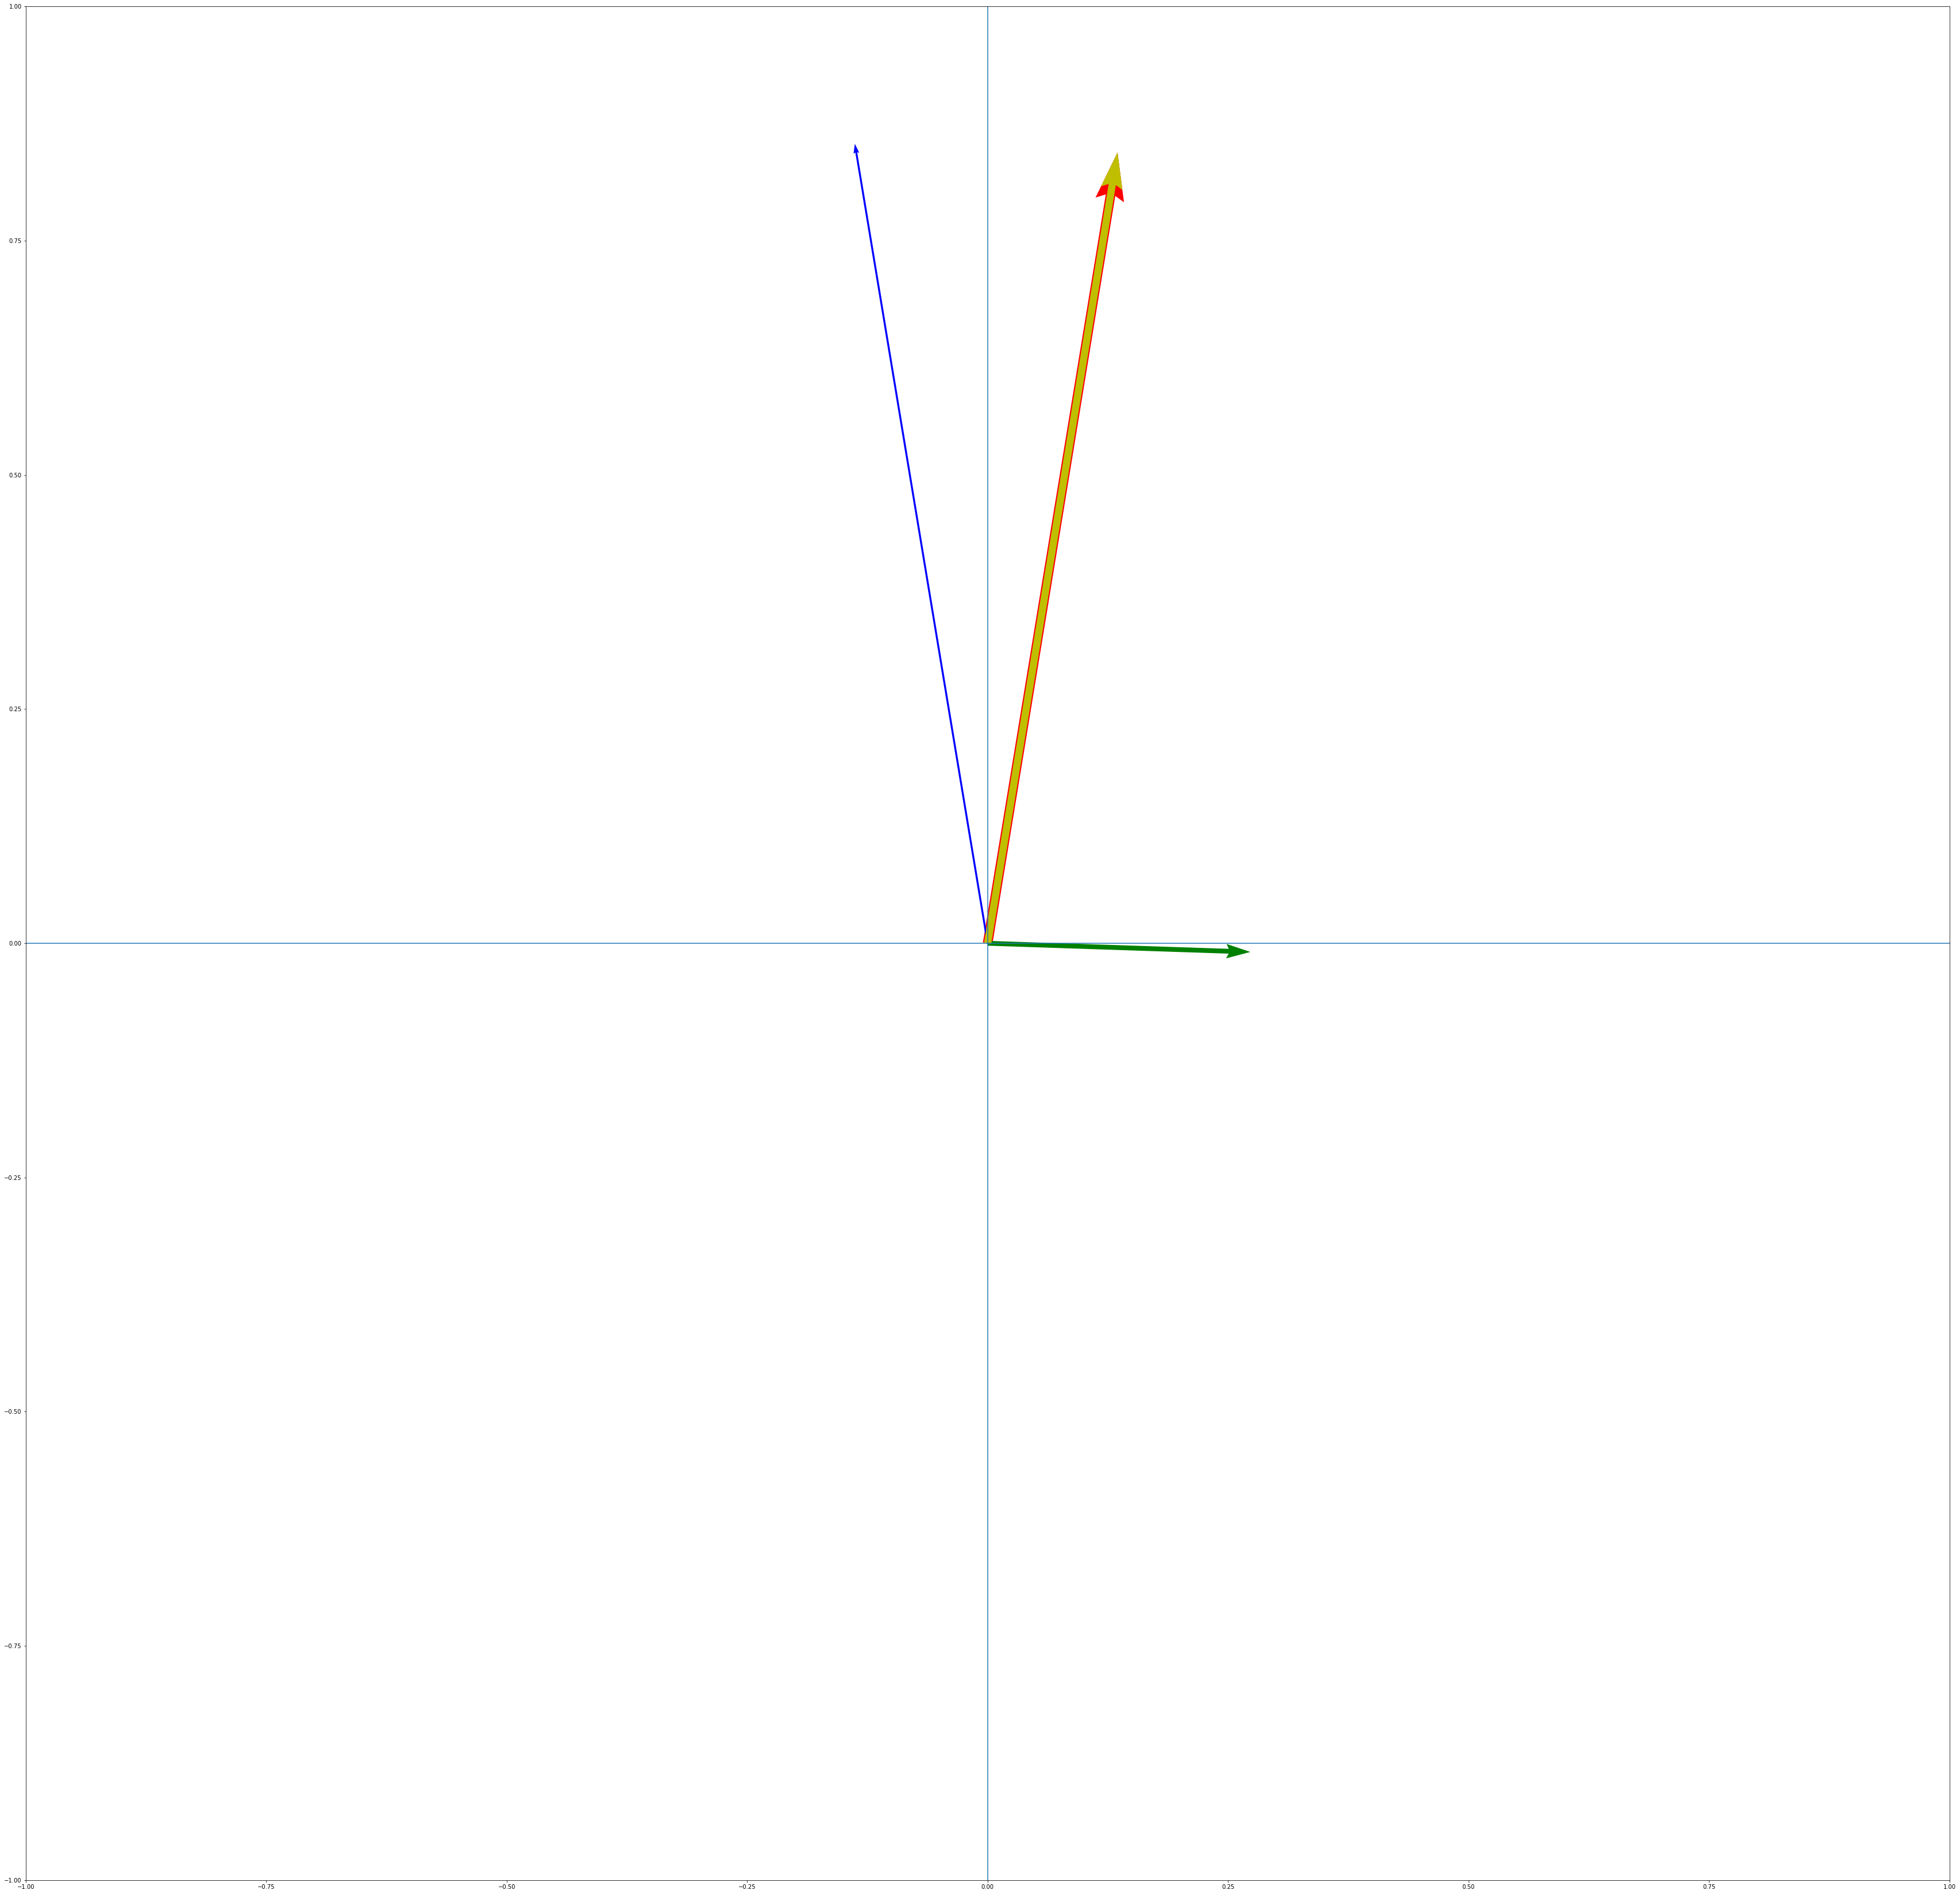

In [27]:
origin = [0], [0]

if nRF==1:
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(60*1)
    fig1.set_figwidth(60)
    axes1.set_xlim([-1,1])
    axes1.set_ylim([-1,1])

    # Vc
    axes1.quiver(0,0,np.real(Vc)/scale_factor,np.imag(Vc)/scale_factor,units = 'x',scale = 1.2,scale_units = 'x', width = 0.01,color = ['r'])

    # Vg
    axes1.quiver(0,0,np.real(Vg)/scale_factor,np.imag(Vg)/scale_factor,units = 'x',scale = 1.2,scale_units = 'x', width = 0.005,color = ['g'])

    # Vb
    axes1.quiver(0,0,np.real(Vb)/scale_factor,np.imag(Vb)/scale_factor,units = 'x',scale = 1.2,scale_units = 'x', width = 0.002,color = ['b'])

    # Vb+Vg
    axes1.quiver(0,0,np.real(Vb+Vg)/scale_factor,np.imag(Vb+Vg)/scale_factor,units = 'x',scale = 1.2,scale_units = 'x', width = 0.0075,color = ['y'])

    axes1.axvline(x = 0)
    axes1.axhline(y = 0)
    plt.show()
else:
    fig1,axes1 = plt.subplots(nRF,1)
    for i in range(nRF):
        axes1[i].set_xlim([-1,1])
        axes1[i].set_ylim([-1,1])

        # Vc
        axes1[i].quiver(0,0,np.real(Vc[i])/scale_factor[i],np.imag(Vc[i])/scale_factor[i],units = 'x',scale = 1.2,scale_units = 'x', width = 0.01,color = ['r'])

        # Vg
        axes1[i].quiver(0,0,np.real(Vg[i])/scale_factor[i],np.imag(Vg[i])/scale_factor[i],units = 'x',scale = 1.2,scale_units = 'x', width = 0.005,color = ['g'])

        # Vb
        axes1[i].quiver(0,0,np.real(Vb[i])/scale_factor[i],np.imag(Vb[i])/scale_factor[i],units = 'x',scale = 1.2,scale_units = 'x', width = 0.002,color = ['b'])

        # Vb+Vg
        axes1[i].quiver(0,0,np.real(Vb+Vg)[i]/scale_factor[i],np.imag(Vb+Vg)[i]/scale_factor[i],units = 'x',scale = 1.2,scale_units = 'x', width = 0.01,color = ['y'])

        axes1[i].axvline(x = 0)
        axes1[i].axhline(y = 0)
    plt.show()

In [115]:
thetaL

-1.5446163880149815

In [116]:
nRF

1

In [117]:
Vc

array([7968302.20626686+2.67843699e+08j])

In [118]:
-VQ/(Vc[0]+Vc[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
-VI/(Vc[0]+Vc[1])

In [ ]:
-IQ*R/(Vc[0]+Vc[1])/2

In [ ]:
-II*R/(Vc[0]+Vc[1])/2